<a href="https://colab.research.google.com/github/GaborVxxx/ml_notes/blob/main/RNN_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:

# https://www.kaggle.com/shivamkushwaha/bbc-full-text-document-classification
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv


File ‘bbc_text_cls.csv’ already there; not retrieving.



In [76]:
from IPython import get_ipython
from IPython.display import display

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import torch

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

In [78]:
df = pd.read_csv('bbc_text_cls.csv')
df.head()

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business


In [79]:

# Make device agnostic code
# device = "cuda" if torch.cuda.is_available() else "cpu" # Original line using Pytorch
device = tf.config.list_physical_devices('GPU')  # Get available GPUs
if device:
    device = '/GPU:0'  # Use the first GPU if available
else:
    device = '/CPU:0'  # Otherwise use the CPU

print(f"Using device: {device}")

Using device: /GPU:0


In [80]:
# Define the device for TensorFlow
if device == "cuda":
    # If a GPU is available, use it
    with tf.device('/GPU:0'):  # Use the first GPU device
        print("Model and data will be placed on the GPU.")
else:
    print("Model and data will be placed on the CPU.")

Model and data will be placed on the CPU.


In [81]:
df['targets'] = df['labels'].astype('category').cat.codes
df.head()

,text,labels,targets
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,0
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,0
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,0
3,High fuel prices hit BA's profits\n\nBritish A...,business,0
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,0


In [82]:
# number of classes
K = df['targets'].nunique()
K

5

In [83]:
# split tha data
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [84]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 2000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df['text']) # when building the vocabularity maping object use the entire dataset, this way the tokenizer see all options

In [85]:
sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

In [86]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 32359 unique tokens.


In [87]:
from re import T
# add padding to tha data to get N x T maatrix
data_train = pad_sequences(sequences_train)
print('Shape of data train matrix:', data_train.shape)
print(data_train)

# get sequence length (this need so the inner value is the same on the 2 data set traing and test, this way we not going to get shape errors)
T = data_train.shape[1]
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test matrix:', data_test.shape)
print(f'Inner shape is equal to {T}. {data_train.shape}:{data_test.shape}, the matrix hase the same number or records in X axis')

Shape of data train matrix: (1780, 2831)
[[   0    0    0 ...    2   98  541]
 [   0    0    0 ...  186   11   29]
 [   0    0    0 ...   36  208  135]
 ...
 [   0    0    0 ...  267  124 1949]
 [   0    0    0 ...  395  808  481]
 [   0    0    0 ... 1443   53  809]]
Shape of data test matrix: (445, 2831)
Inner shape is equal to 2831. (1780, 2831):(445, 2831), the matrix hase the same number or records in X axis


In [88]:
# Move data to the selected device
with tf.device(device):  # Using tf.device with the previously defined device
    data_train = tf.constant(data_train)  # Convert to TensorFlow tensor
    data_test = tf.constant(data_test)    # Convert to TensorFlow tensor

In [89]:
# create the model

# the embedding dimensions
D = 20

# note: we want the size of the embedding to (V + 1) x D,
# because the forst index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it must have size V + 1.

# Place model creation within the device context
with tf.device(device):
    i = Input(shape=(T,))
    x = Embedding(V + 1, D)(i)
    x = LSTM(32, return_sequences=True)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(K)(x)

    model = Model(i, x)

In [90]:
# Experiments:
# 1, multiple LSTM mayers
# 2, GRU insted of LSTM
# 3, SimpleRNN insted of other RNN layers (GRU, LSTM)
# 4, return_sequence=False, and no maxpooling
# 5, try different values of number of hidden units
# 6, any combination of the above...

In [91]:
# compile the model and fit
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['sparse_categorical_accuracy']
)

In [92]:
r = model.fit(
    data_train, df_train['targets'].values,
    validation_data=(data_test, df_test['targets'].values),
    epochs=10,
    batch_size=32
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 1.6033 - sparse_categorical_accuracy: 0.2442 - val_loss: 1.5607 - val_sparse_categorical_accuracy: 0.4854
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 1.5678 - sparse_categorical_accuracy: 0.3673 - val_loss: 1.4390 - val_sparse_categorical_accuracy: 0.6292
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 1.3197 - sparse_categorical_accuracy: 0.6008 - val_loss: 1.0510 - val_sparse_categorical_accuracy: 0.7303
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.8880 - sparse_categorical_accuracy: 0.7481 - val_loss: 0.9463 - val_sparse_categorical_accuracy: 0.6360
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.7064 - sparse_categorical_accuracy: 0.8313 - val_loss: 0.5628 - val_sparse_categorical_accuracy: 0.8921
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 0.5880 - sparse_categorical_accuracy: 0.8737 - val_loss: 0.5015 - val_sparse_categorical_accuracy: 0.8989
Epoch 7/10

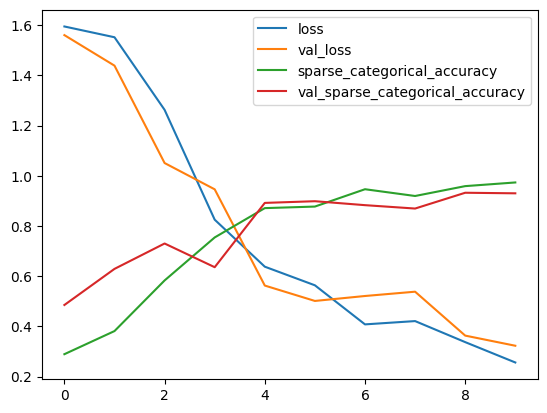

In [94]:
# plot loss and accuracy
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.plot(r.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
plt.plot(r.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
plt.legend()

In [95]:
# Get predictions on the test set
y_pred_probs = model.predict(data_test)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [96]:
# make F1
from sklearn.metrics import f1_score

# Calculate F1 score
f1 = f1_score(df_test['targets'].values, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1}")

Weighted F1 Score: 0.9304724654506304


In [97]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(df_test['targets'].values, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.93       115
           1       0.90      0.89      0.90        72
           2       0.86      0.92      0.89        76
           3       0.98      0.99      0.99       102
           4       0.96      0.91      0.94        80

    accuracy                           0.93       445
   macro avg       0.93      0.93      0.93       445
weighted avg       0.93      0.93      0.93       445



In [98]:
# MAKE A PREDICTION
new_string = "This is a random string about technology and innovation."

new_string_sequence = tokenizer.texts_to_sequences([new_string]) # Convert to sequence
new_string_padded = pad_sequences(new_string_sequence, maxlen=T) # Pad to match model input shape

prediction_probs = model.predict(new_string_padded)  # Get predicted probabilities
predicted_label_index = np.argmax(prediction_probs) # Get the index of the predicted label

# Assuming df['labels'] contains the original label names
label_names = df['labels'].astype('category').cat.categories
predicted_label = label_names[predicted_label_index]
print(f"Predicted Label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Predicted Label: tech
